# Some ideas for DoE Tests

In [1]:
import math

import luxpy as lx
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

%run -i jhelp

%matplotlib inline

from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.spectral import MCSpectrumSamples, generate_FourierMC0
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
    array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result, sumMC, sumMCV, plotCorrMatrixSmall
from empir19nrm02.f1prime import py_f1PrimeG,  py_f1PrimeGlx

from empir19nrm02 import _SPD, _RES

from numpy.linalg import norm, inv
from scipy.stats import chi2

print('Version of luxpy:', lx.__version__)
out_dir = 'DoE'


Version of luxpy: v1.9.6


# Parameter for the simulation
#### Let's modify some standard data first and calculate some integrated values like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 1000

bIdeal = False
bSimDetector = False    # True use RES for Simulation, False use SPD for simulation
selected_detector = 73
selected_SPD = 2 # 1=NLA, 2=L41

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function or a white PT-LED example)

In [3]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], wl_new = np.arange(wlStart,wlStop+1,wlResolution), kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector/SPD and sore all together into a class instance SPD from luxpy

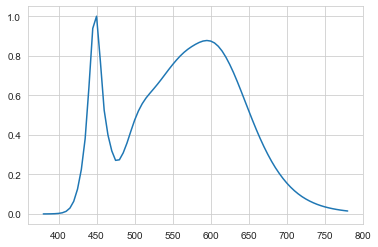

In [4]:
# Using a detector responsivity for the simulation
if bSimDetector:
    if bIdeal:
        # using an ideal detector
        wl=lxCmfInterpolate[0].reshape(1,res)
        value=lxCmfInterpolate[2].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        # using an detector from the data base
        from empir19nrm02 import _RES
        wl= _RES['VLDetectors']['S']['data'][0].copy()
        value= _RES['VLDetectors']['S']['data'][selected_detector].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)
# Using a SD for the simulation
else:
    if bIdeal:
        # using an ideal SD (e.g. illumiant L)
        lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['LED_L41'], \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S')
        wl=lxSpdInterpolate[0].reshape(1,res)
        value=lxSpdInterpolate[1].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        # using a ideal SD from the PhotoLED project
        from empir19nrm02 import _SPD
        wl= _SPD['PHOTOLED']['S']['data'][0].copy()
        value= _SPD['PHOTOLED']['S']['data'][selected_SPD].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)

spd_init[1,:]=spd_init[1,:]/np.max(spd_init[1,:])

pyplot.plot( spd_init[0],spd_init[1])


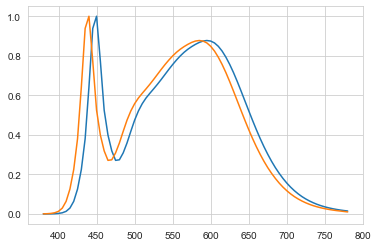

Yxy: [[5.3008e+04 3.7560e-01 3.7229e-01]]
Yxy_shift: [[5.4174e+04 3.6373e-01 3.7601e-01]]
Diff x: 0.01187371307794055, Diff y: -0.0037177179847183717


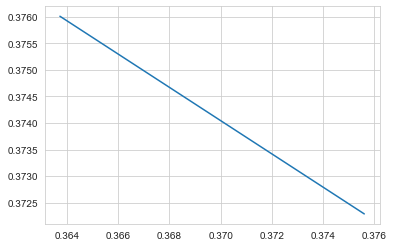

In [5]:
lxspd = lx.spd(spd_init)
XYZ = lx.spd_to_xyz( lxspd, relative=False, cieobs='1931_2')
Yxy = lx.xyz_to_Yxy (XYZ)


shift = 10
spd_wlshift = lx.cie_interp(spd_init, \
            wl_new = shift + np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)
spd_wlshift[0] = spd_init[0]

pyplot.plot( spd_init[0],spd_init[1])
pyplot.plot( spd_wlshift[0],spd_wlshift[1])
pyplot.show()

XYZ_shift = lx.spd_to_xyz( spd_wlshift, relative=False, cieobs='1931_2')
Yxy_shift = lx.xyz_to_Yxy (XYZ_shift)

print('Yxy:', Yxy)
print('Yxy_shift:', Yxy_shift)
print(f'Diff x: {Yxy[0][1]-Yxy_shift[0][1]}, Diff y: {Yxy[0][2]-Yxy_shift[0][2]}')

pyplot.plot( [Yxy[0][1],Yxy_shift[0][1]],[Yxy[0][2],Yxy_shift[0][2]])


# Scale to reference?
* True:    all graphs will be shown as difference to the reference
* False:   all graphs will be shown as they are (without referencing the data)

In [6]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The usage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

The last version 'cov' means, that the simulation will be done based on the covaricane matrix and not based on the model
parameter variation.

In [7]:
mc_enable = { 'nothing': True,
              'wl_noise_nc': True,          # non correlated wavelength noise
              'wl_noise_c': True,           # correlated wavelength noise
              'wl_fourier_noise':True,      # fourier correlated wavelength noise
              'value_noise_nc': True,       # non correlated value noise
              'value_noise_c': True,        # correlated value noise
              'value_fourier_noise':True,   # fourier correlated value noise
              'all': True,                  # all components together
              'cov': False,                 # simulation based on the covariance matrix and multivariate gaussian noise only
              'file': False,                # simulation from a former simulation
              }

mc_disable = mc_enable.copy()
for key in mc_disable:
    mc_disable[key]=False

mc_cov = mc_disable.copy()
mc_cov['cov']=True

mc_file = mc_disable.copy()
mc_file['file']=True


In [8]:
# THX: https://stackoverflow.com/questions/7965743/how-can-i-set-the-aspect-ratio-in-matplotlib
def aspectratio_to_one( ax):
    ratio = 1.0
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

def showResults( samples, name):
    print( samples.MCTable)
    samples.MCTable.to_excel(get_fig_file_name(dir=out_dir, filename= name + '.xlsx', table=True))

    v_wl_ref, v_wl, v_wl_diff, v_mean, v_mean_diff, v_std, q_min, q_max, cov_image, corr_image, counts = samples.get_result()

    fig, ax1 = pyplot.subplots()
    ax1.plot( v_wl_ref, v_mean, label=name+' mean')
    ax1.plot( v_wl_ref, v_std, label=name+' std')
    ax1.fill_between( v_wl_ref, q_min, q_max)
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel( 'mean; stddev / A.U.', fontsize=label_font_size)
    ax1.legend()
    save_fig(dir=out_dir, filename=name)

    fig, ax1 = pyplot.subplots()
    ax1.plot( v_wl_ref, v_mean_diff, label=name+' mean diff')
    ax1.plot( v_wl_ref, v_std, label=name+' stddev')
    ax1.fill_between( v_wl_ref, q_min-v_mean, q_max-v_mean)
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel( 'mean dif; stddev / A.U.', fontsize=label_font_size)
    ax1.legend()
    save_fig(dir=out_dir, filename=name+'Diff')

    plotCorrelation( cov_image, v_wl_ref, name + 'Covariance')
    save_fig(dir=out_dir, filename=name+'cov')

    plotCorrelation( corr_image, v_wl_ref, name + 'Correlation')
    save_fig(dir=out_dir, filename=name+'corr')

    return cov_image

In [9]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# THX: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, fill=False, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Running the MC simulation

# Generate a first MC Simulation
* take the initial spectral data (SD or responsivity)
* generate some noise on the value scale only
* run the MC simulation
* calculate statistical results
* save the data as csv and binary (okl) file
* show some results

nothing
generate_random_numbers
wl_noise_nc
generate_random_numbers
A
wl_noise_c
generate_random_numbers
B
wl_fourier_noise
generate_random_numbers
C
value_noise_nc
generate_random_numbers
D
value_noise_c
generate_random_numbers
E
value_fourier_noise
generate_random_numbers
F
all
generate_random_numbers
A
B
C
D
E
F
           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.37577

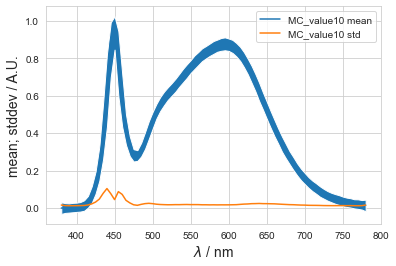

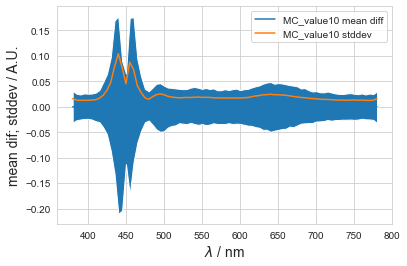

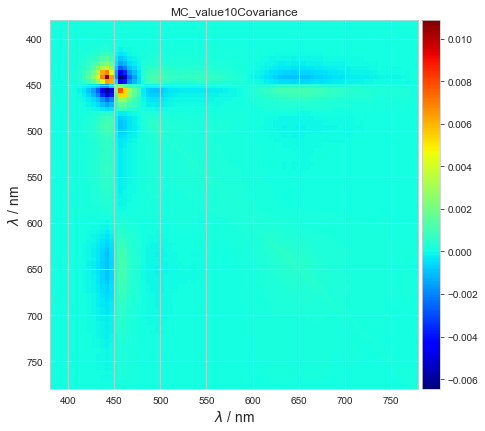

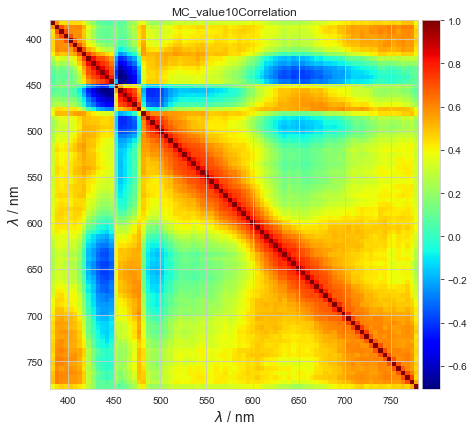

In [10]:
whished_results = ['x', 'y']
whished_results_str = [ 'x', 'y']

mcSpectrumSamples = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_value = mc_enable.copy()
mcSpectrumSamples.run_MC(mc_value, whished_results)
mcSpectrumSamples.calc_summary(wavelength_stat=False)
mcSpectrumSamples.save_to_csv()
mcSpectrumSamples.save()

cov_image = showResults(mcSpectrumSamples, 'MC_value'+str(shift))

nothing
generate_random_numbers
wl_noise_nc
generate_random_numbers
A
wl_noise_c
generate_random_numbers
B
wl_fourier_noise
generate_random_numbers
C
value_noise_nc
generate_random_numbers
D
value_noise_c
generate_random_numbers
E
value_fourier_noise
generate_random_numbers
F
all
generate_random_numbers
A
B
C
D
E
F
           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.37577

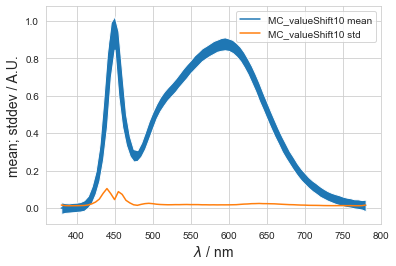

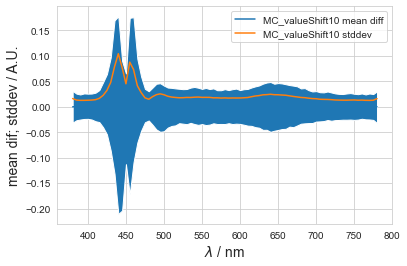

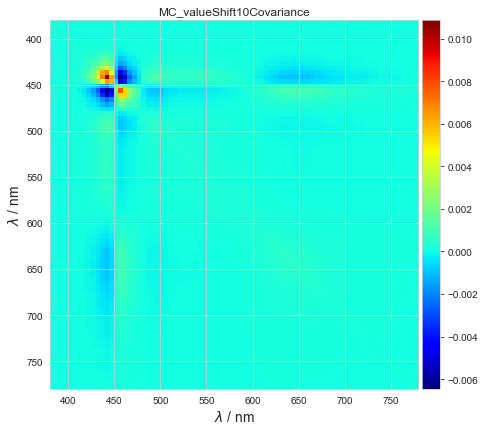

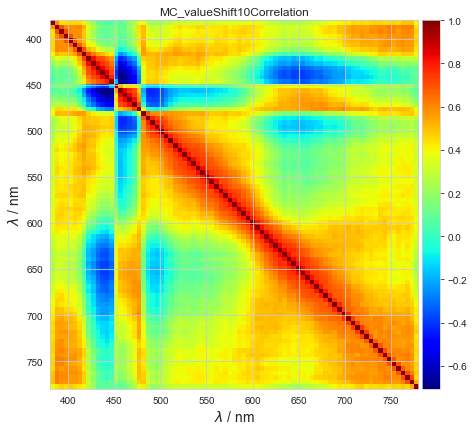

In [11]:
def make2ndMC( shift_loc, spd_shift):
    mcSpectrumSamples2 = MCSpectrumSamples(spd=spd_shift, trials=trials)
    mc_value = mc_enable.copy()
    mcSpectrumSamples2.run_MC(mc_value, whished_results)
    mcSpectrumSamples2.calc_summary(wavelength_stat=False)
    mcSpectrumSamples2.save_to_csv()
    mcSpectrumSamples2.save()
    return mcSpectrumSamples2

mcSpectrumSamples2 = make2ndMC(shift, spd_wlshift)
cov_image2 = showResults(mcSpectrumSamples, 'MC_valueShift'+str(shift))

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


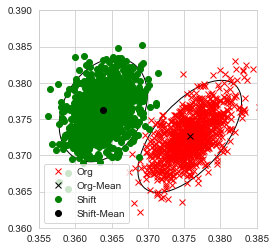

In [12]:
def plotxySingle(shift_loc, mcSpectrumSamples2_loc):
    fig, ax1 = pyplot.subplots()
    ax1.plot(mcSpectrumSamples.spectrumResults.result['x']['data'],mcSpectrumSamples.spectrumResults.result['y']['data'], 'rx' , label = 'Org')
    ax1.plot(mcSpectrumSamples.spectrumResults.result['x']['Mean'],mcSpectrumSamples.spectrumResults.result['y']['Mean'], 'kx' , label = 'Org-Mean')
    ax1.plot(mcSpectrumSamples2_loc.spectrumResults.result['x']['data'],mcSpectrumSamples2_loc.spectrumResults.result['y']['data'] , 'go', label = 'Shift')
    ax1.plot(mcSpectrumSamples2_loc.spectrumResults.result['x']['Mean'],mcSpectrumSamples2_loc.spectrumResults.result['y']['Mean'], 'ko' , label = 'Shift-Mean')
    confidence_ellipse(mcSpectrumSamples.spectrumResults.result['x']['data'],mcSpectrumSamples.spectrumResults.result['y']['data'], ax1, n_std=2.45, edgecolor='k')
    confidence_ellipse(mcSpectrumSamples2_loc.spectrumResults.result['x']['data'],mcSpectrumSamples2_loc.spectrumResults.result['y']['data'], ax1, n_std=2.45, edgecolor='k')
    ax1.legend()
    ax1.grid(b=True)
    ax1.set_xlim([0.355,0.385])
    ax1.set_ylim([0.360,0.390])
    aspectratio_to_one(ax1)

    save_fig(dir=out_dir, filename='xyBoth'+str(shift_loc))

plotxySingle(shift, mcSpectrumSamples2)

In [16]:
def calcMeanCov(mcSpectrumSamples_loc):
    x1 = np.array((mcSpectrumSamples_loc.spectrumResults.result['x']['Mean'],mcSpectrumSamples_loc.spectrumResults.result['y']['Mean']))
    data_x1 = np.array((mcSpectrumSamples_loc.spectrumResults.result['x']['data'],mcSpectrumSamples_loc.spectrumResults.result['y']['data']))
    cov1 = mcSpectrumSamples_loc.spectrumResults.get_table_covariane(['x', 'y'])
    return x1, cov1

x1, cov1 = calcMeanCov(mcSpectrumSamples)
x2, cov2 = calcMeanCov(mcSpectrumSamples2)

print( x1, cov1)
print( x2, cov2)

[3.7577e-01 3.7261e-01] [[8.5210e-06 5.6226e-06]
 [5.6226e-06 9.9729e-06]]
[3.6383e-01 3.7624e-01] [[6.1632e-06 2.0962e-06]
 [2.0962e-06 8.4861e-06]]


Evaluation according to Zeier
https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.513.2806

* multi variate degree of equivalence $\boldsymbol{d}_{i}$ is a vector of dimension $m$
* assuming an $m$-variate normal distribution
* $mxm$ covariance matrix
* confidence region around $\boldsymbol{d}_{i}$
* for $\chi_{m,\alpha}^{2}$ usually the inverse of the culmulative pdf of the $\chi^{2}$ distribution with $m$degrees of freedom for the confidence level $alpha=0.95$ is used. (Example  $\chi_{2,0.95}^{2}=6$) 

* $(\boldsymbol{x}-\boldsymbol{d}_{i})^{\mathrm{T}}{\boldsymbol{V}_{\boldsymbol{d}_{i}}}^{-1}(\boldsymbol{x}-\boldsymbol{d}_{i})=\chi_{m,\alpha}^{2}$

In [22]:
def calc_multiDim_DoE( x1_, cov1_, x2_, cov2_, data_=None):
    d = x1_-x2_
    V=cov1_+cov2_
    if data_ is None:
        data_ = np.random.default_rng().multivariate_normal(d, V, 1000)
        data_ = data_.T
    # We need to use the inverse of the cumulative distribution
    df=cov1_.shape[0]
    chisquare = chi2.ppf(0.95, df=df)

    d_norm = norm(d)
    print('chisquare:', chisquare)
    print('Difference Vecotr:', d, d_norm)
    print('Resulting Covariance Matrix:',V)
    d_y = math.sqrt(1./(d.T @ inv(V) @ d)*chisquare)
    print('dy:', d_y*d_norm)
    print('DoE:', 1/d_y)
    return d, d_y, V, data_

chisquare: 5.991464547107979
Difference Vecotr: [1.1937e-02 -3.6377e-03] 0.012478713502866952
Resulting Covariance Matrix: [[1.4684e-05 7.7188e-06]
 [7.7188e-06 1.8459e-05]]
dy: 0.007513765166395823
DoE: 1.660780344676742


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


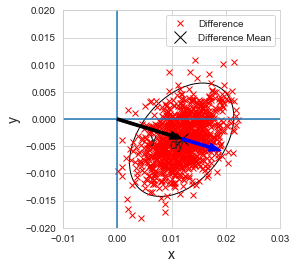

In [23]:
d, dy, V, data = calc_multiDim_DoE(x1, cov1, x2, cov2)

def plot_multi_DoE( shift_loc, d_, dy_, V_, data_):
    fig, ax1 = pyplot.subplots()
    ax1.plot(data_[0], data_[1], 'rx' , label = 'Difference')
    ax1.plot(d_[0], d_[1], 'kx' , label = 'Difference Mean', markersize=12)
    confidence_ellipse(data_[0],data_[1], ax1, n_std=2.45, edgecolor='k')
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim([-0.01, 0.03])
    ax1.set_ylim([-0.02, 0.02])
    ax1.grid(b=True)
    ax1.legend()
    ax1.arrow(0,0, d_[0], d_[1], width=.0005, color='black', length_includes_head=True, zorder=100)
    ax1.arrow(d_[0],d_[1], dy_*d_[0], dy_*d_[1], width=.0005, color='blue', length_includes_head=True, zorder=100)

    ax1.text(d_[0]/2, d_[1]/2-0.0025, "y",fontsize=label_font_size)
    ax1.text((dy_*d_[0]+d_[0])/2, (dy_*d_[1]+d_[1])/2-0.0025, "dy",fontsize=label_font_size)

    ax1.set_xlabel('x', fontsize=label_font_size)
    ax1.set_ylabel('y', fontsize=label_font_size)

    aspectratio_to_one(ax1)


    save_fig(dir=out_dir, filename='2dDoE'+str(shift_loc))

plot_multi_DoE( shift, d, dy, V, data)

In [39]:
sd1 = mcSpectrumSamples.v_mean
sd2 = mcSpectrumSamples2.v_mean
d1, dy1, V1, data1 = calc_multiDim_DoE(sd1, cov_image, sd2, cov_image2)


chisquare: 103.00950871222618
Difference Vecotr: [-5.8795e-04 -9.1700e-04 -1.9734e-03 -4.7604e-03 -1.0857e-02 -2.5816e-02
 -5.3471e-02 -9.8516e-02 -1.6340e-01 -2.6217e-01 -4.1235e-01 -5.0681e-01
 -3.1083e-01 1.2806e-01 4.1365e-01 3.6407e-01 2.1869e-01 1.2816e-01
 4.5789e-02 -3.1330e-02 -7.9906e-02 -1.0564e-01 -1.1329e-01 -1.0103e-01
 -8.4458e-02 -6.6746e-02 -5.3890e-02 -4.6966e-02 -4.6484e-02 -4.8168e-02
 -5.0629e-02 -5.1786e-02 -5.0589e-02 -4.7786e-02 -4.4200e-02 -3.9316e-02
 -3.4913e-02 -2.9487e-02 -2.5625e-02 -2.1528e-02 -1.6963e-02 -9.3995e-03
 -7.5436e-05 1.1603e-02 2.5091e-02 4.0781e-02 5.3977e-02 6.7023e-02
 7.8124e-02 8.6530e-02 9.3394e-02 9.6483e-02 9.8232e-02 9.8690e-02
 9.4925e-02 9.0378e-02 8.6981e-02 8.0221e-02 7.3167e-02 6.7898e-02
 6.1568e-02 5.4949e-02 4.9237e-02 4.3555e-02 3.8808e-02 3.3800e-02
 3.0331e-02 2.6574e-02 2.2548e-02 1.9699e-02 1.6739e-02 1.4857e-02
 1.2991e-02 1.1287e-02 8.9550e-03 7.9223e-03 6.6614e-03 5.9556e-03
 5.9023e-03 5.5030e-03 5.4717e-03] 1.103645

# Summarizing all the calculations while changing shift

nothing
generate_random_numbers
wl_noise_nc
generate_random_numbers
A
wl_noise_c
generate_random_numbers
B
wl_fourier_noise
generate_random_numbers
C
value_noise_nc
generate_random_numbers
D
value_noise_c
generate_random_numbers
E
value_fourier_noise
generate_random_numbers
F
all
generate_random_numbers
A
B
C
D
E
F
           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.37577

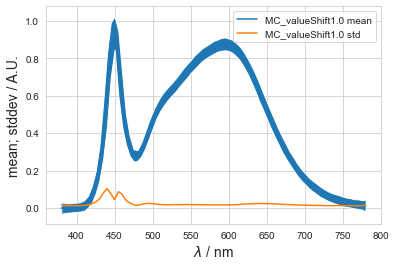

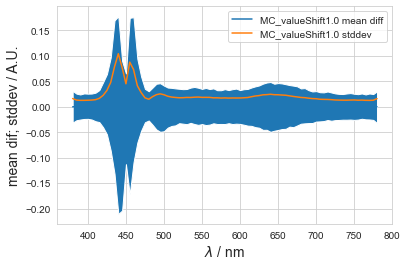

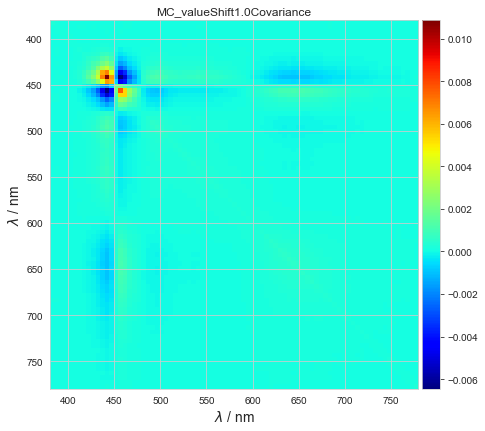

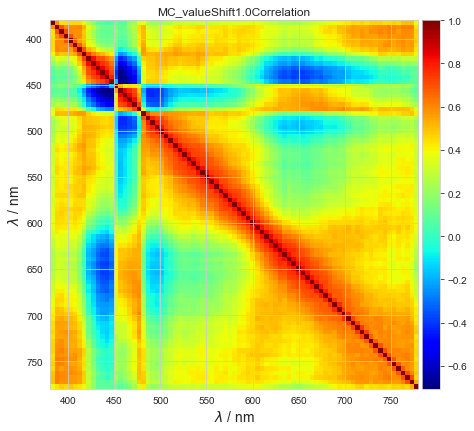

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


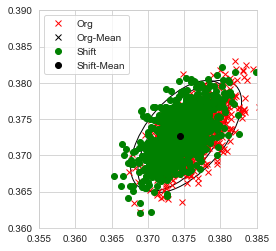

chisquare: 5.991464547107979
Difference Vecotr: [1.3859e-03 -9.1388e-05] 0.0013889126879038406
Resulting Covariance Matrix: [[1.6165e-05 1.0465e-05]
 [1.0465e-05 1.9664e-05]]
dy: 0.0077058083211519355
DoE: 0.18024230943966862


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


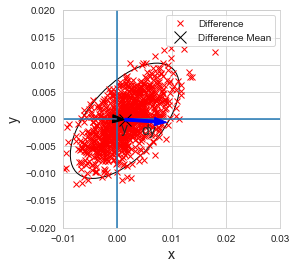

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

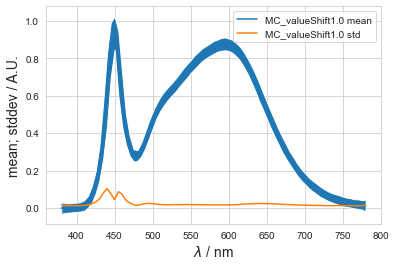

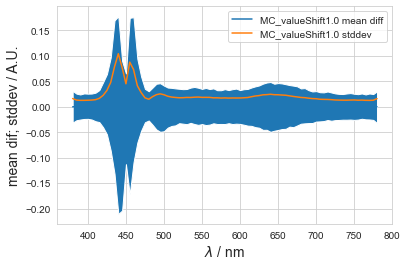

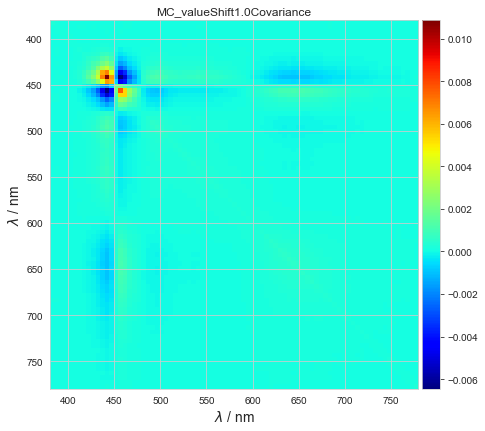

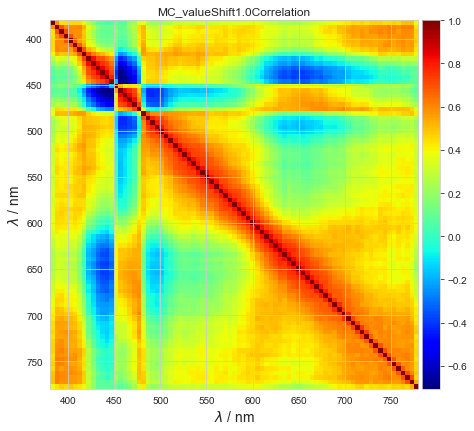

chisquare: 103.00950871222618
Difference Vecotr: [4.0212e-05 4.7432e-04 3.5326e-04 -3.7985e-05 -1.4893e-04 -1.2436e-03
 -2.4209e-03 -5.0989e-03 -9.5804e-03 -1.7702e-02 -2.7398e-02 -4.7682e-02
 -5.9915e-02 -3.2393e-02 2.6094e-02 4.8607e-02 3.7042e-02 2.1165e-02
 1.3315e-02 4.5759e-03 -4.3494e-03 -9.1626e-03 -1.1496e-02 -1.0927e-02
 -1.0270e-02 -8.8329e-03 -7.4086e-03 -5.1497e-03 -4.8959e-03 -5.4034e-03
 -5.3902e-03 -6.0295e-03 -6.0056e-03 -6.1817e-03 -5.2212e-03 -4.1807e-03
 -4.6039e-03 -3.9520e-03 -3.3900e-03 -2.7852e-03 -2.7991e-03 -1.6548e-03
 -9.4375e-04 -3.2464e-04 1.0574e-03 2.4061e-03 3.9678e-03 6.3495e-03
 7.9132e-03 8.8607e-03 1.0217e-02 1.0469e-02 1.1099e-02 1.2029e-02
 1.0648e-02 1.0056e-02 1.0865e-02 1.0186e-02 9.4146e-03 9.0437e-03
 8.0656e-03 7.0221e-03 6.0080e-03 5.7373e-03 4.1260e-03 3.9159e-03
 4.1299e-03 3.0509e-03 2.7844e-03 2.6769e-03 2.3513e-03 1.8167e-03
 1.5843e-03 1.6785e-03 9.1370e-04 1.4287e-03 7.1287e-04 5.6799e-04
 1.7119e-03 1.0123e-03 2.3697e-04] 0.12514042

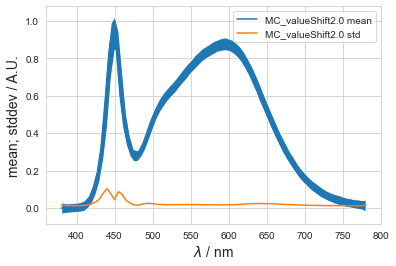

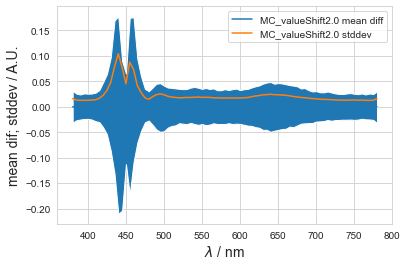

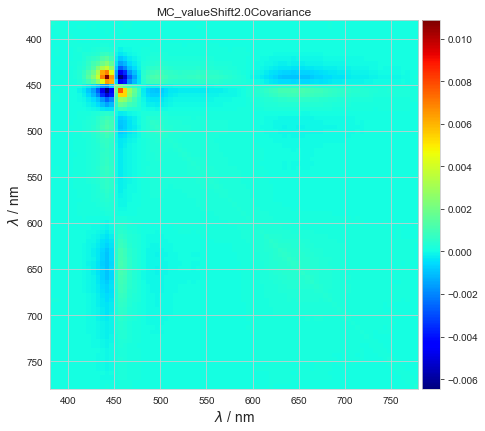

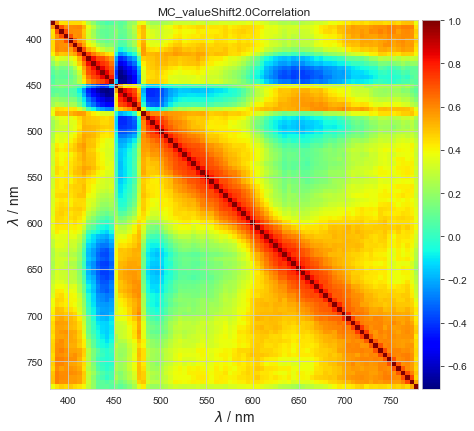

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


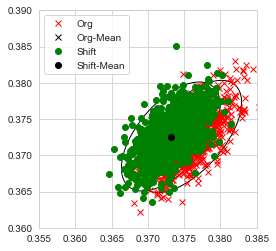

chisquare: 5.991464547107979
Difference Vecotr: [2.6252e-03 1.3191e-05] 0.002625215259448088
Resulting Covariance Matrix: [[1.6225e-05 1.0551e-05]
 [1.0551e-05 1.9394e-05]]
dy: 0.007947532228177035
DoE: 0.3303182905179923


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


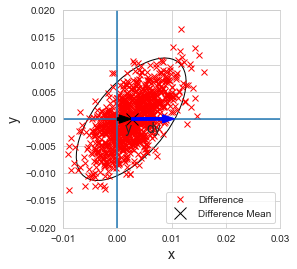

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

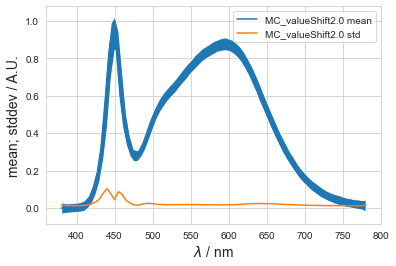

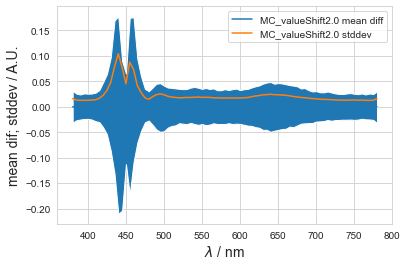

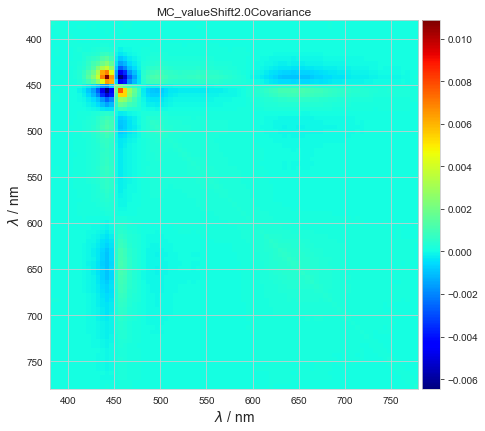

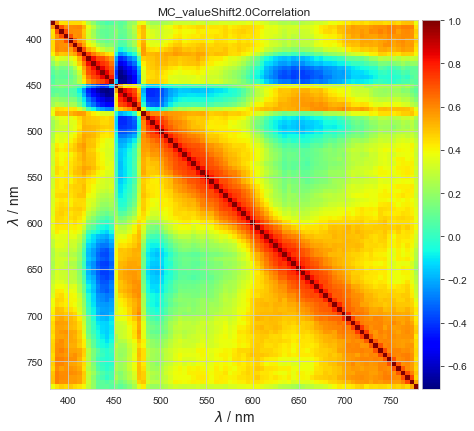

chisquare: 103.00950871222618
Difference Vecotr: [1.2517e-03 5.8663e-04 1.6946e-04 -1.1627e-04 -4.4340e-04 -1.9081e-03
 -5.4021e-03 -1.0680e-02 -2.0290e-02 -3.4122e-02 -5.5201e-02 -9.0603e-02
 -1.0960e-01 -5.2541e-02 5.2334e-02 9.2111e-02 6.3662e-02 3.6694e-02
 2.2778e-02 5.6905e-03 -9.2962e-03 -1.7605e-02 -2.2861e-02 -2.2445e-02
 -2.0660e-02 -1.6336e-02 -1.2831e-02 -9.5111e-03 -8.4120e-03 -8.6797e-03
 -9.2120e-03 -1.0266e-02 -9.9647e-03 -9.1550e-03 -8.4314e-03 -7.0914e-03
 -7.2250e-03 -6.3539e-03 -5.3144e-03 -4.9889e-03 -4.2123e-03 -3.0577e-03
 -1.6113e-03 -1.1865e-05 2.2970e-03 5.6132e-03 8.5208e-03 1.2330e-02
 1.4384e-02 1.6698e-02 1.8919e-02 1.8953e-02 1.9900e-02 2.1028e-02
 1.9239e-02 1.8455e-02 1.9680e-02 1.7923e-02 1.5789e-02 1.4968e-02
 1.4400e-02 1.2665e-02 1.1008e-02 1.0051e-02 8.3297e-03 8.0007e-03
 7.1961e-03 6.2162e-03 5.1305e-03 4.8791e-03 4.0322e-03 3.6891e-03
 2.9521e-03 3.3319e-03 2.3397e-03 2.7495e-03 1.7908e-03 1.3674e-03
 1.6559e-03 1.6754e-03 1.1181e-03] 0.23075529

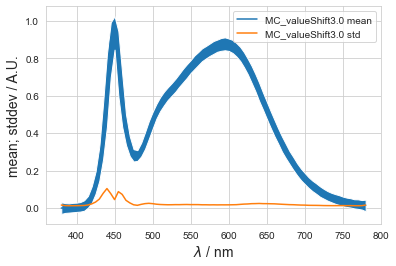

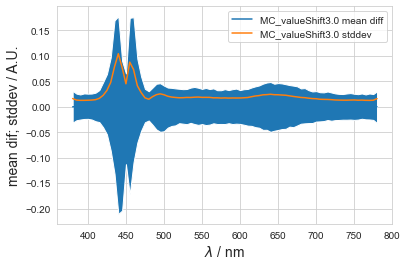

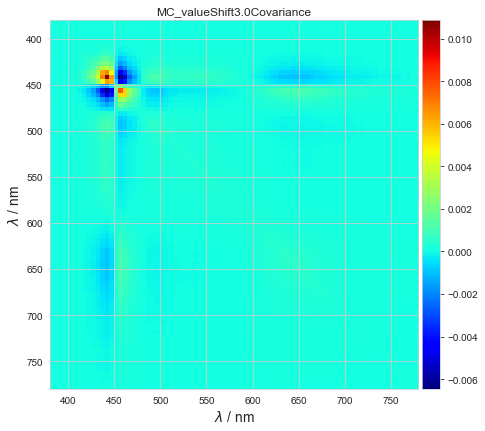

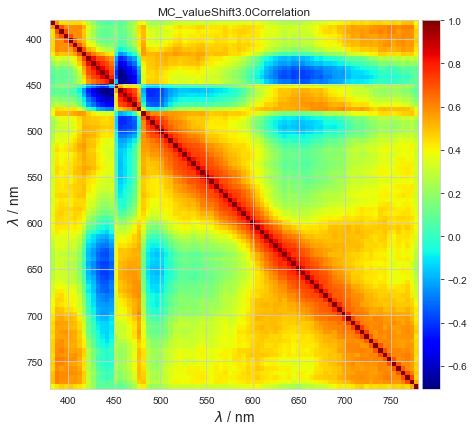

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


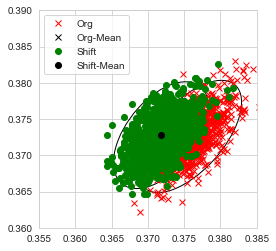

chisquare: 5.991464547107979
Difference Vecotr: [3.9526e-03 -1.7382e-04] 0.003956400639137521
Resulting Covariance Matrix: [[1.5714e-05 9.7669e-06]
 [9.7669e-06 1.9015e-05]]
dy: 0.007832499796650702
DoE: 0.505126171957175


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


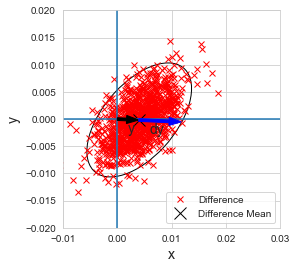

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

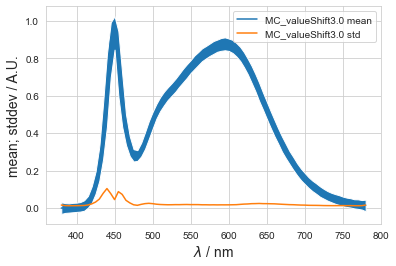

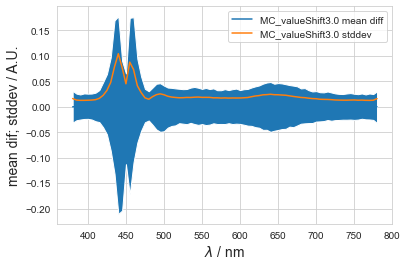

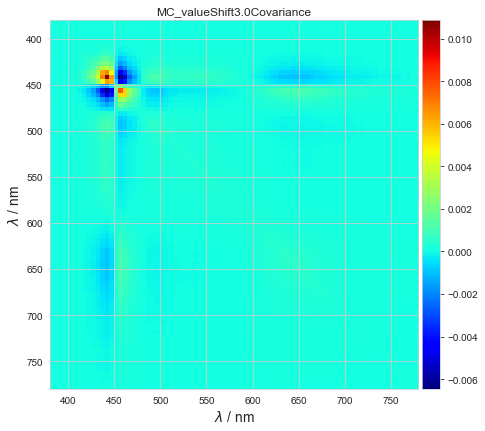

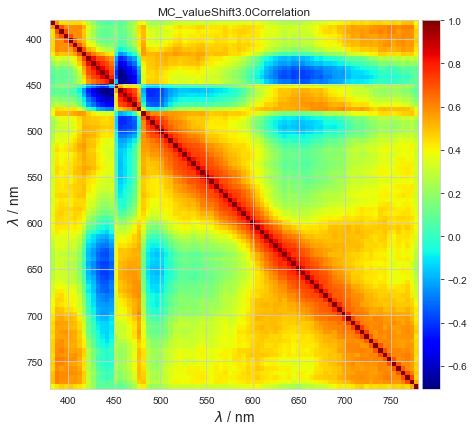

chisquare: 103.00950871222618
Difference Vecotr: [-2.6855e-04 -1.0723e-04 -1.7311e-04 -2.4235e-04 -1.3808e-03 -3.8688e-03
 -9.0937e-03 -1.8281e-02 -3.4862e-02 -5.6752e-02 -8.8939e-02 -1.4438e-01
 -1.6955e-01 -6.6753e-02 9.6870e-02 1.4469e-01 9.2046e-02 5.3777e-02
 3.2373e-02 5.6461e-03 -1.6704e-02 -2.8443e-02 -3.4964e-02 -3.3743e-02
 -3.0216e-02 -2.4404e-02 -1.8980e-02 -1.5132e-02 -1.4018e-02 -1.4357e-02
 -1.5357e-02 -1.5913e-02 -1.5722e-02 -1.5270e-02 -1.4184e-02 -1.1705e-02
 -1.1024e-02 -9.2881e-03 -7.9939e-03 -6.8524e-03 -6.2088e-03 -4.9525e-03
 -2.3541e-03 4.4665e-04 4.6021e-03 9.4791e-03 1.3893e-02 1.8156e-02
 2.1429e-02 2.5024e-02 2.8088e-02 2.8971e-02 2.9102e-02 3.0205e-02
 2.8839e-02 2.7406e-02 2.7820e-02 2.6371e-02 2.4366e-02 2.2908e-02
 2.0507e-02 1.8446e-02 1.6878e-02 1.5070e-02 1.2697e-02 1.1774e-02
 1.0803e-02 9.6286e-03 7.7500e-03 6.8181e-03 5.5005e-03 4.8033e-03
 3.8505e-03 3.9700e-03 3.1291e-03 2.8530e-03 2.2549e-03 2.4094e-03
 2.7330e-03 2.1051e-03 1.6202e-03] 0.358509

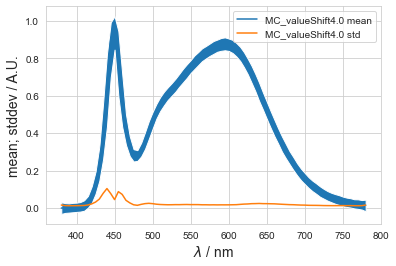

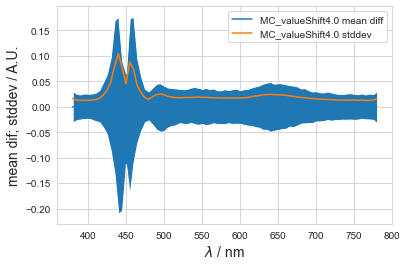

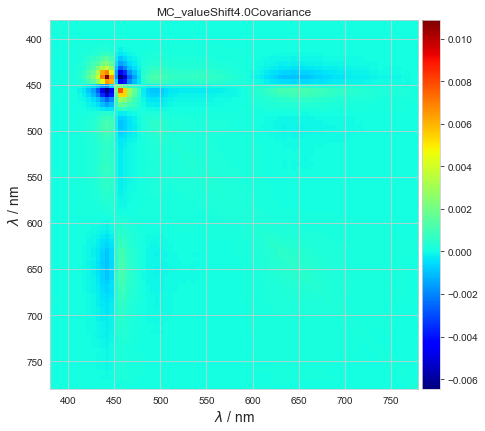

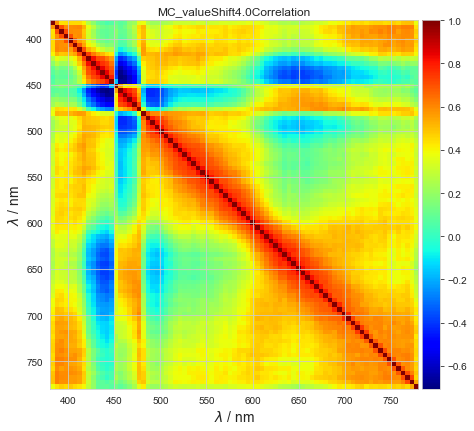

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


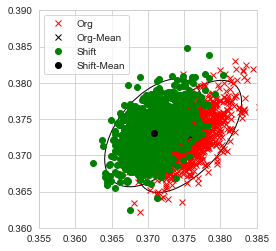

chisquare: 5.991464547107979
Difference Vecotr: [4.9604e-03 -5.0312e-04] 0.004985864009175034
Resulting Covariance Matrix: [[1.6168e-05 9.7349e-06]
 [9.7349e-06 1.9222e-05]]
dy: 0.007823282090932238
DoE: 0.6373110353458964


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


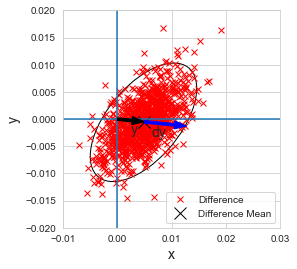

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

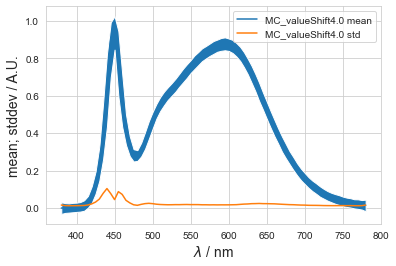

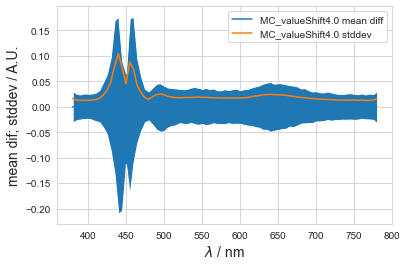

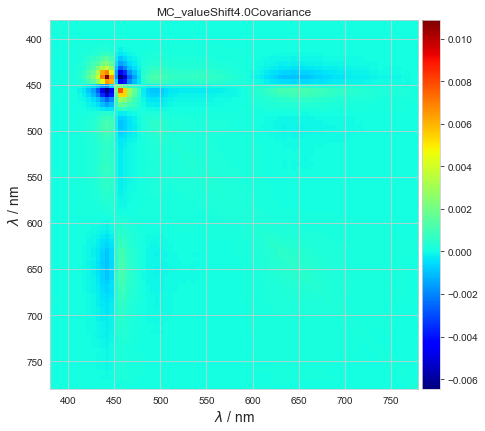

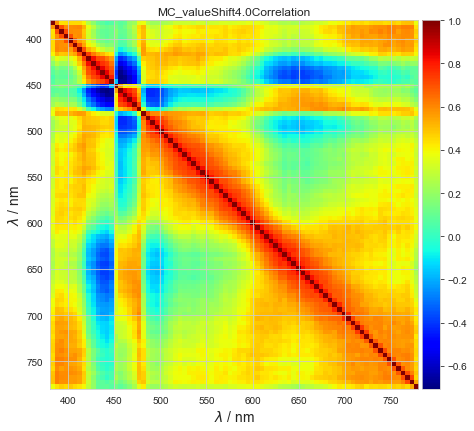

chisquare: 103.00950871222618
Difference Vecotr: [1.8501e-04 -1.5399e-05 -6.6280e-04 -1.3367e-03 -2.6695e-03 -5.4373e-03
 -1.3041e-02 -2.5083e-02 -4.4978e-02 -7.5713e-02 -1.2133e-01 -1.9307e-01
 -2.1438e-01 -6.7226e-02 1.3830e-01 1.8419e-01 1.1418e-01 6.8349e-02
 3.9813e-02 3.3786e-03 -2.3969e-02 -3.7568e-02 -4.5160e-02 -4.3036e-02
 -3.8528e-02 -3.0703e-02 -2.4492e-02 -1.9546e-02 -1.8009e-02 -1.8902e-02
 -1.9921e-02 -2.1629e-02 -2.0678e-02 -2.0148e-02 -1.8834e-02 -1.6679e-02
 -1.5261e-02 -1.2778e-02 -1.0889e-02 -9.9922e-03 -8.3819e-03 -5.7550e-03
 -3.0152e-03 8.9863e-04 5.5022e-03 1.1748e-02 1.7624e-02 2.3167e-02
 2.7446e-02 3.1603e-02 3.4977e-02 3.6396e-02 3.7682e-02 3.9396e-02
 3.7397e-02 3.6567e-02 3.6072e-02 3.4023e-02 3.1141e-02 2.8949e-02
 2.6399e-02 2.3191e-02 2.0904e-02 1.8924e-02 1.6722e-02 1.4147e-02
 1.3173e-02 1.1194e-02 9.9515e-03 9.0747e-03 7.3711e-03 6.3527e-03
 5.8107e-03 4.8775e-03 3.8692e-03 3.4717e-03 2.9683e-03 2.6113e-03
 2.8711e-03 2.4784e-03 1.8984e-03] 0.4636210

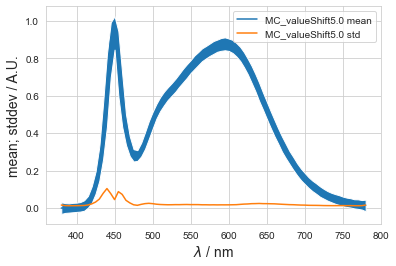

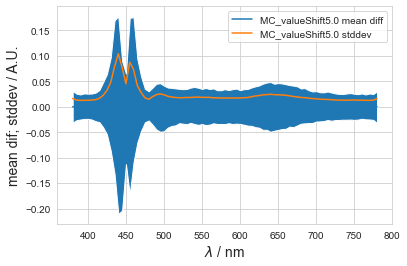

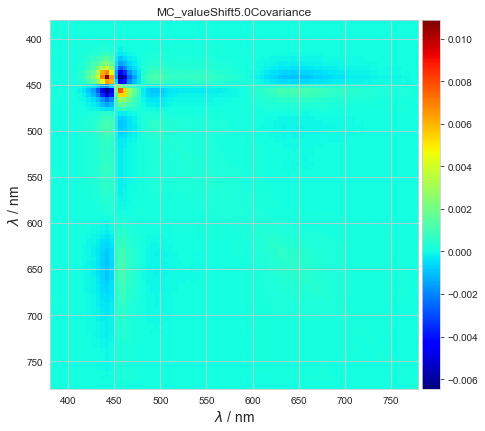

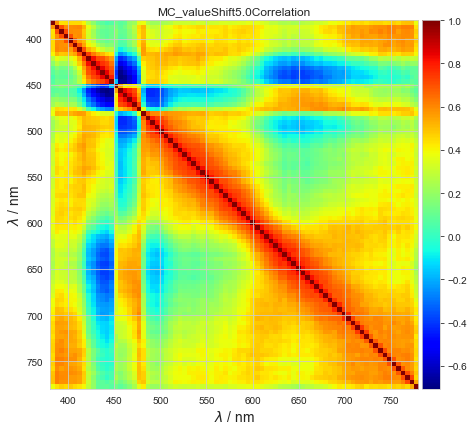

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


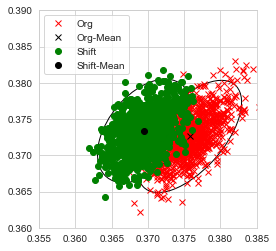

chisquare: 5.991464547107979
Difference Vecotr: [6.2724e-03 -7.6149e-04] 0.006318429942833457
Resulting Covariance Matrix: [[1.5459e-05 9.0751e-06]
 [9.0751e-06 1.8456e-05]]
dy: 0.007685997138584178
DoE: 0.8220702960081198


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


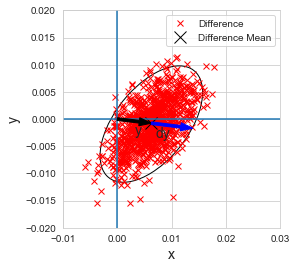

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

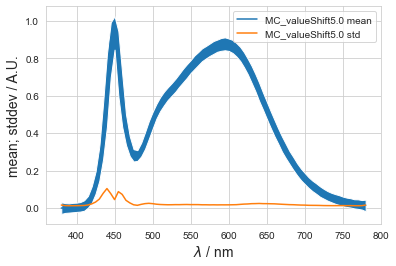

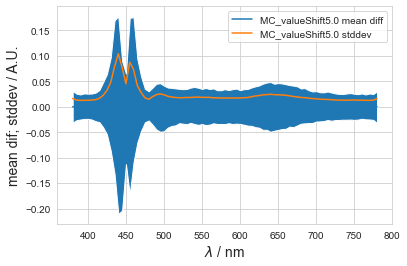

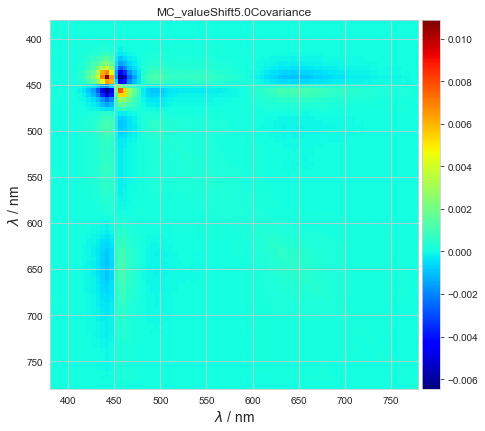

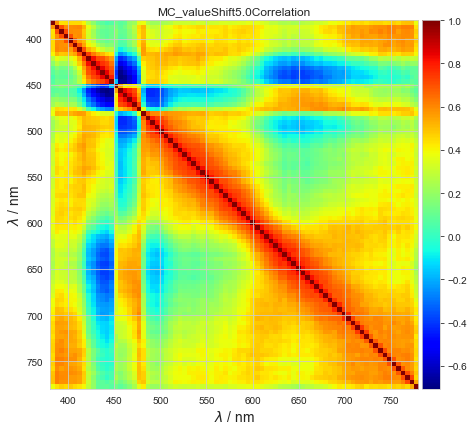

chisquare: 103.00950871222618
Difference Vecotr: [-6.4064e-04 2.4434e-05 -6.4694e-04 -1.9404e-03 -3.2911e-03 -7.7591e-03
 -1.8472e-02 -3.5355e-02 -6.1872e-02 -1.0187e-01 -1.6249e-01 -2.5079e-01
 -2.5661e-01 -5.5380e-02 1.8685e-01 2.2521e-01 1.3635e-01 8.2622e-02
 4.5339e-02 5.3060e-04 -3.1923e-02 -4.9079e-02 -5.7451e-02 -5.4516e-02
 -4.7197e-02 -3.7583e-02 -2.9664e-02 -2.4122e-02 -2.2392e-02 -2.2834e-02
 -2.4461e-02 -2.6095e-02 -2.5378e-02 -2.4680e-02 -2.2354e-02 -1.9848e-02
 -1.8616e-02 -1.6167e-02 -1.3752e-02 -1.1645e-02 -1.0204e-02 -7.3694e-03
 -3.0990e-03 1.7462e-03 8.1335e-03 1.6508e-02 2.3814e-02 3.1055e-02
 3.7054e-02 4.1463e-02 4.5722e-02 4.8217e-02 4.9565e-02 5.0367e-02
 4.8790e-02 4.6520e-02 4.4177e-02 4.2218e-02 3.8897e-02 3.5983e-02
 3.2408e-02 2.8818e-02 2.5116e-02 2.3219e-02 2.0270e-02 1.7990e-02
 1.6021e-02 1.3858e-02 1.2066e-02 1.0516e-02 8.8512e-03 7.8404e-03
 6.7321e-03 5.9682e-03 4.9277e-03 4.5871e-03 3.5213e-03 2.9601e-03
 3.2756e-03 2.9329e-03 2.4553e-03] 0.5812100

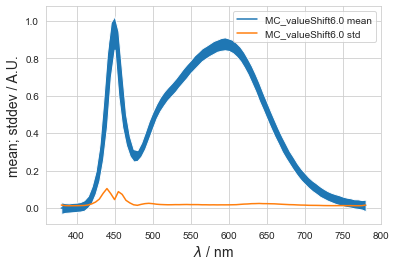

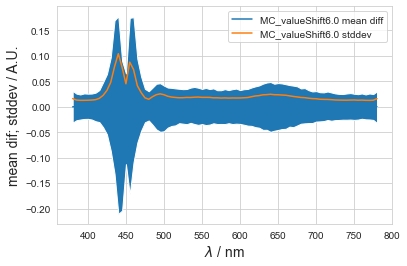

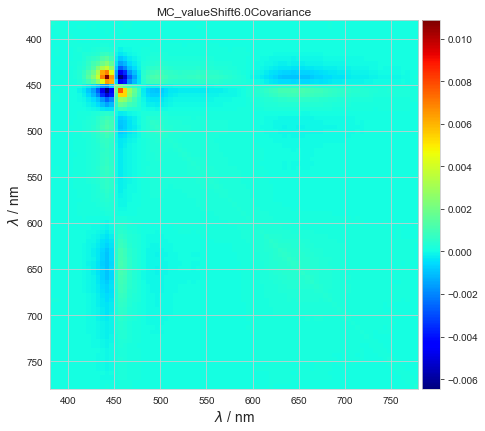

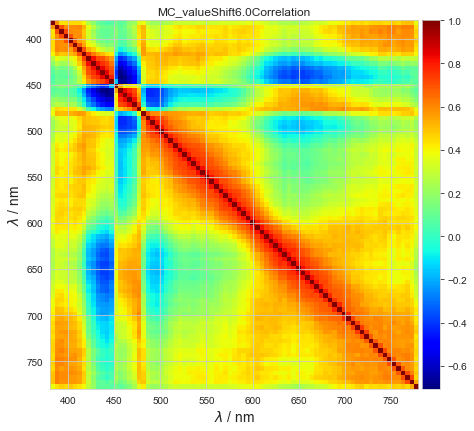

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


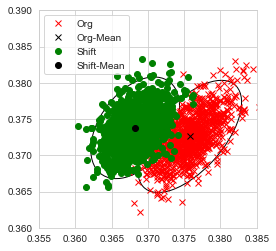

chisquare: 5.991464547107979
Difference Vecotr: [7.5301e-03 -1.1884e-03] 0.007623272340989776
Resulting Covariance Matrix: [[1.4764e-05 8.6870e-06]
 [8.6870e-06 1.8164e-05]]
dy: 0.00745818520404229
DoE: 1.0221350278158834


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


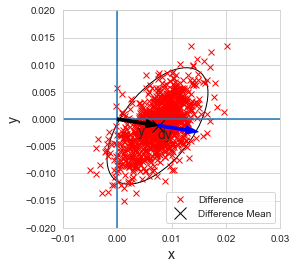

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

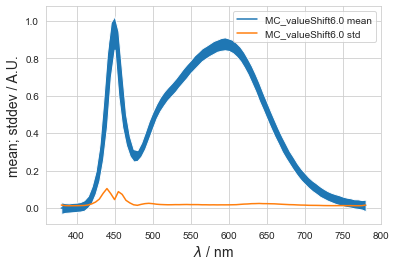

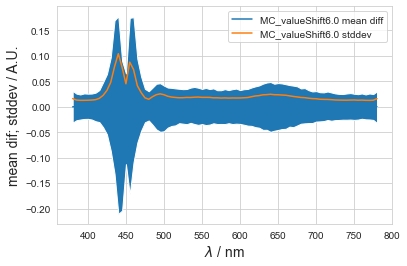

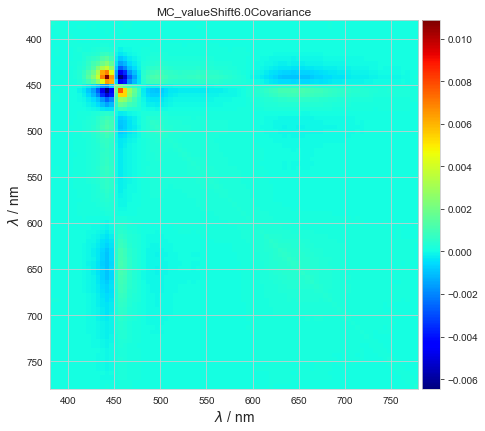

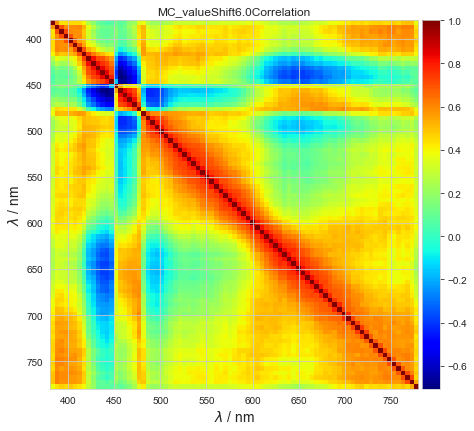

chisquare: 103.00950871222618
Difference Vecotr: [-9.9259e-04 -5.8290e-04 -1.4285e-03 -2.4663e-03 -4.8361e-03 -1.0927e-02
 -2.3857e-02 -4.6349e-02 -8.0214e-02 -1.2950e-01 -2.0845e-01 -3.0896e-01
 -2.8840e-01 -3.3622e-02 2.3584e-01 2.6203e-01 1.5649e-01 9.4770e-02
 4.9095e-02 -3.9452e-03 -4.1395e-02 -5.9979e-02 -6.8954e-02 -6.5455e-02
 -5.6207e-02 -4.4637e-02 -3.4816e-02 -2.9280e-02 -2.7768e-02 -2.8573e-02
 -3.0090e-02 -3.1853e-02 -3.0867e-02 -2.9886e-02 -2.7415e-02 -2.4565e-02
 -2.2167e-02 -1.8503e-02 -1.5615e-02 -1.3736e-02 -1.1264e-02 -8.1598e-03
 -3.3157e-03 3.6478e-03 1.1399e-02 2.0687e-02 2.9426e-02 3.8116e-02
 4.4903e-02 5.0592e-02 5.5646e-02 5.7946e-02 5.9143e-02 5.9777e-02
 5.8227e-02 5.5945e-02 5.4250e-02 4.9987e-02 4.6305e-02 4.3002e-02
 3.8582e-02 3.4426e-02 3.0862e-02 2.7682e-02 2.4033e-02 2.1219e-02
 1.9114e-02 1.6301e-02 1.4152e-02 1.2182e-02 1.0322e-02 8.6802e-03
 7.4591e-03 6.9189e-03 4.7981e-03 4.6795e-03 4.0338e-03 3.1219e-03
 2.9326e-03 2.7167e-03 1.7325e-03] 0.69493

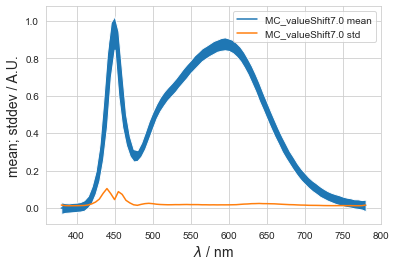

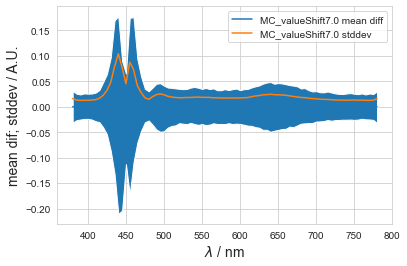

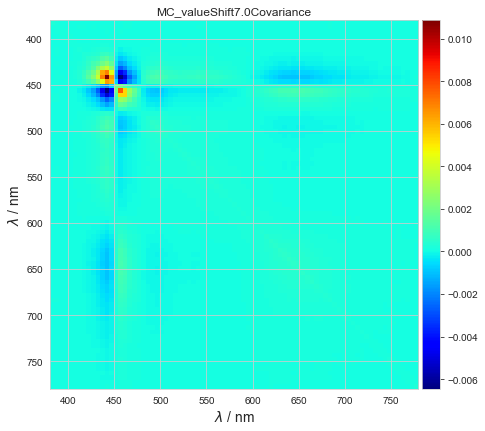

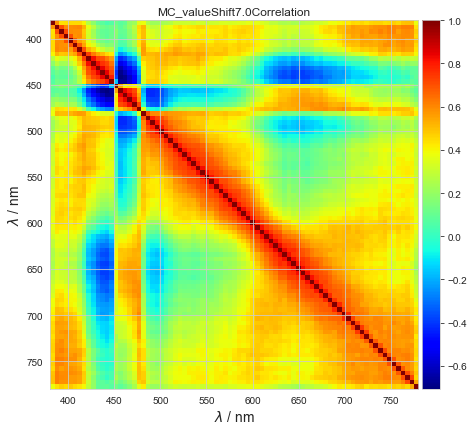

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


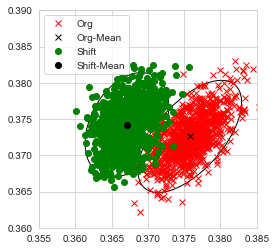

chisquare: 5.991464547107979
Difference Vecotr: [8.6580e-03 -1.5845e-03] 0.008801793887679583
Resulting Covariance Matrix: [[1.4064e-05 8.0151e-06]
 [8.0151e-06 1.8662e-05]]
dy: 0.00745819656153971
DoE: 1.1801504311469224


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


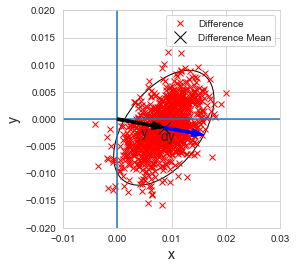

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

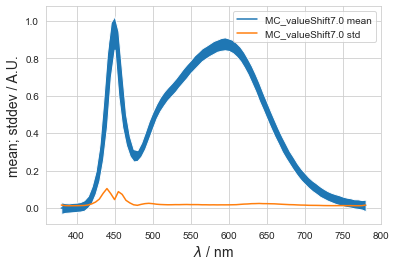

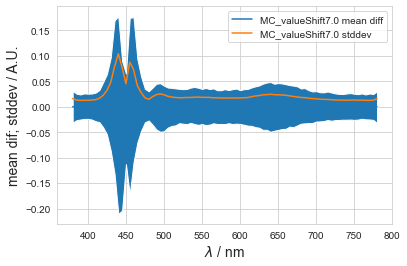

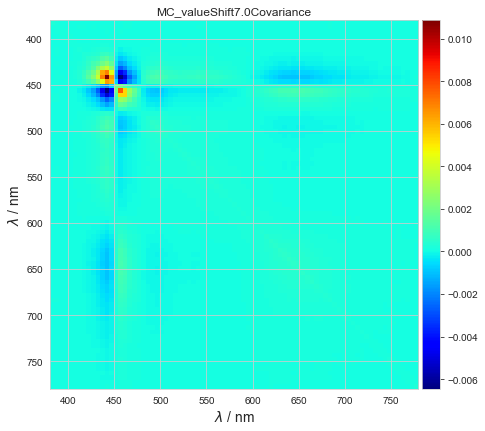

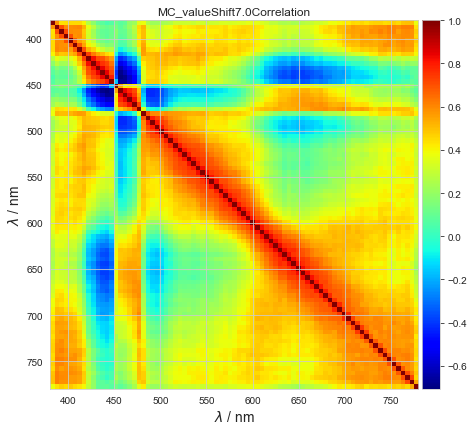

chisquare: 103.00950871222618
Difference Vecotr: [-3.6511e-04 -1.8393e-04 -1.3420e-03 -2.9550e-03 -6.1715e-03 -1.3614e-02
 -2.9884e-02 -5.6963e-02 -9.8081e-02 -1.5887e-01 -2.5388e-01 -3.6678e-01
 -3.1313e-01 -1.9782e-03 2.8326e-01 2.9048e-01 1.7353e-01 1.0509e-01
 4.9596e-02 -1.0446e-02 -5.0950e-02 -7.2015e-02 -8.1279e-02 -7.5792e-02
 -6.4410e-02 -5.0418e-02 -3.9892e-02 -3.3470e-02 -3.2443e-02 -3.3633e-02
 -3.5218e-02 -3.7010e-02 -3.6407e-02 -3.4320e-02 -3.2126e-02 -2.8805e-02
 -2.5637e-02 -2.2319e-02 -1.9049e-02 -1.6566e-02 -1.4684e-02 -9.7564e-03
 -3.6788e-03 3.2365e-03 1.3658e-02 2.4153e-02 3.4125e-02 4.4206e-02
 5.2529e-02 5.8735e-02 6.4678e-02 6.6819e-02 6.8342e-02 6.9482e-02
 6.7745e-02 6.3533e-02 6.1820e-02 5.7882e-02 5.3455e-02 4.9636e-02
 4.4114e-02 3.9295e-02 3.5257e-02 3.2069e-02 2.7819e-02 2.4398e-02
 2.1748e-02 1.8959e-02 1.5756e-02 1.3869e-02 1.1168e-02 1.0267e-02
 9.1127e-03 7.3026e-03 5.7817e-03 5.1085e-03 4.4913e-03 3.5993e-03
 3.8086e-03 3.7109e-03 3.3871e-03] 0.80230

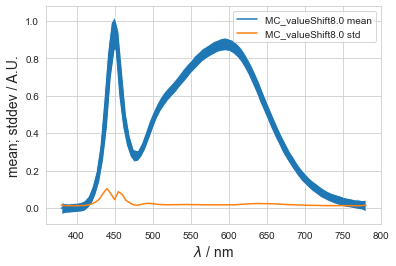

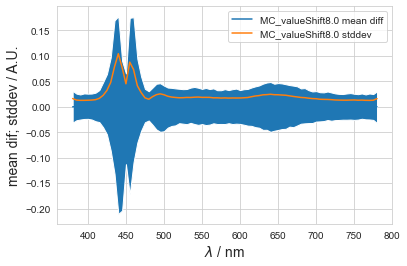

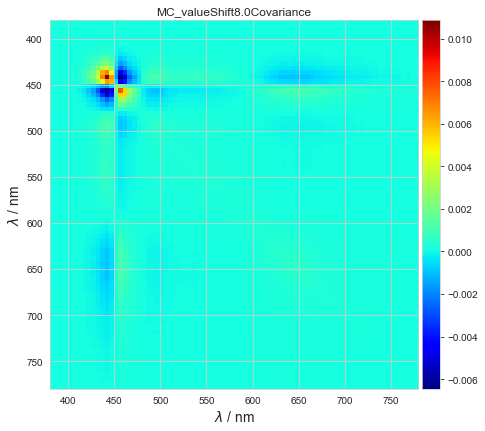

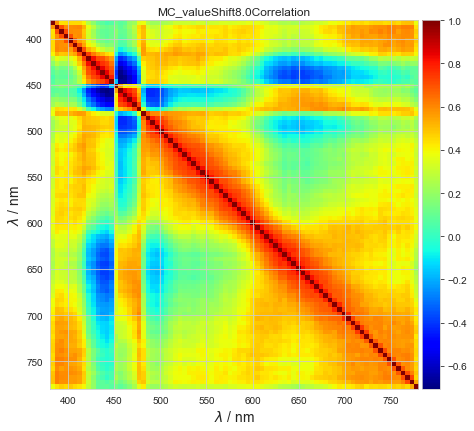

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


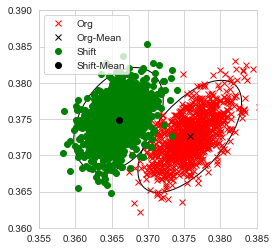

chisquare: 5.991464547107979
Difference Vecotr: [9.8271e-03 -2.2877e-03] 0.010089900744117631
Resulting Covariance Matrix: [[1.4857e-05 8.4275e-06]
 [8.4275e-06 1.8656e-05]]
dy: 0.007462034361106833
DoE: 1.3521648729879354


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


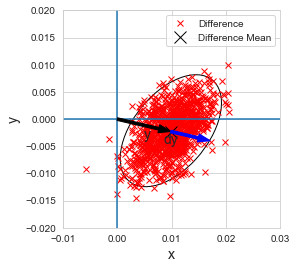

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

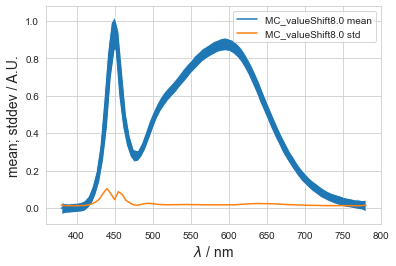

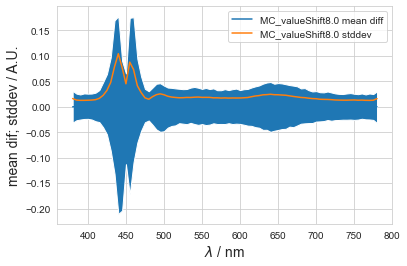

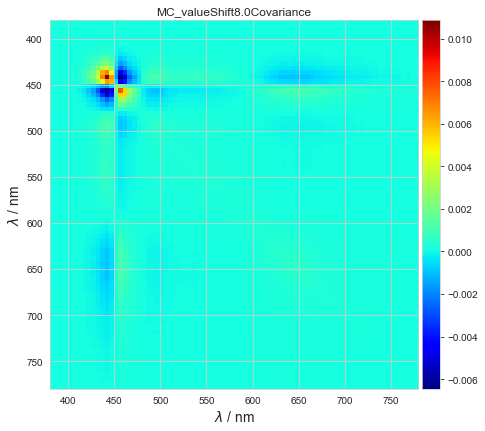

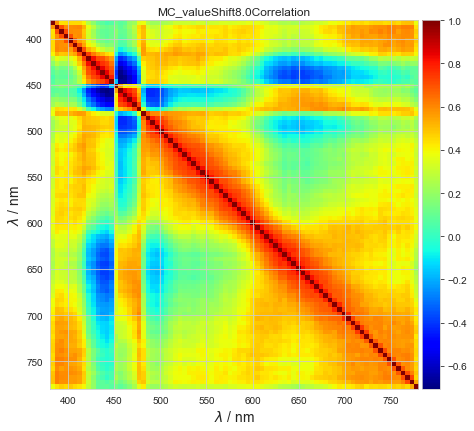

chisquare: 103.00950871222618
Difference Vecotr: [-6.6165e-04 -4.1892e-04 -1.6011e-03 -3.1244e-03 -7.3047e-03 -1.7245e-02
 -3.7091e-02 -7.0476e-02 -1.1926e-01 -1.9067e-01 -3.0608e-01 -4.2179e-01
 -3.2445e-01 3.9753e-02 3.3270e-01 3.1984e-01 1.9105e-01 1.1526e-01
 5.0645e-02 -1.6353e-02 -6.0568e-02 -8.3511e-02 -9.1080e-02 -8.3862e-02
 -7.1400e-02 -5.6264e-02 -4.5149e-02 -3.8178e-02 -3.6820e-02 -3.8163e-02
 -4.0575e-02 -4.1597e-02 -4.0801e-02 -3.8651e-02 -3.6030e-02 -3.2362e-02
 -2.8867e-02 -2.3971e-02 -2.0982e-02 -1.8034e-02 -1.4288e-02 -9.3038e-03
 -1.9663e-03 6.9090e-03 1.8601e-02 3.0528e-02 4.1894e-02 5.3086e-02
 6.1939e-02 6.8673e-02 7.5125e-02 7.8176e-02 7.8923e-02 8.0408e-02
 7.6966e-02 7.4023e-02 7.1094e-02 6.5483e-02 6.0495e-02 5.5995e-02
 5.0516e-02 4.5807e-02 3.9799e-02 3.6687e-02 3.1866e-02 2.8550e-02
 2.5146e-02 2.1357e-02 1.8238e-02 1.6308e-02 1.4030e-02 1.1731e-02
 1.0250e-02 8.9372e-03 7.7988e-03 6.4615e-03 5.4301e-03 4.6798e-03
 4.8601e-03 4.2080e-03 3.1480e-03] 0.911858

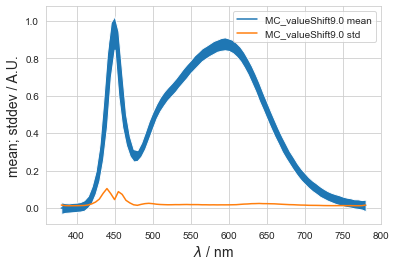

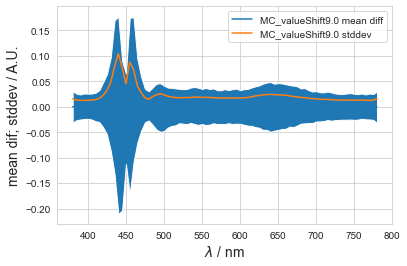

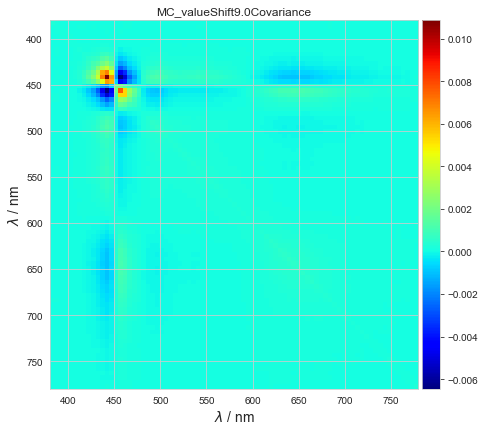

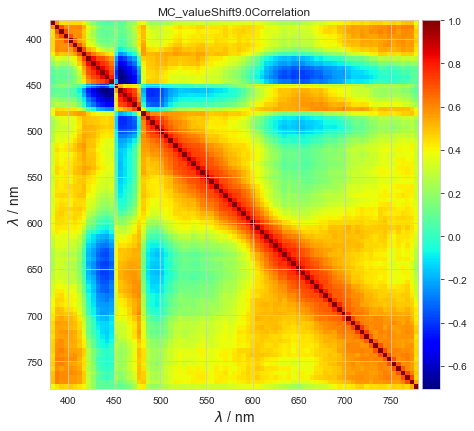

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


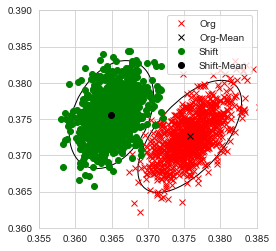

chisquare: 5.991464547107979
Difference Vecotr: [1.0805e-02 -3.0152e-03] 0.01121756013806032
Resulting Covariance Matrix: [[1.4162e-05 8.0811e-06]
 [8.0811e-06 1.9214e-05]]
dy: 0.007334545477939704
DoE: 1.5294144908910383


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


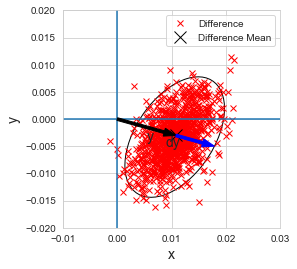

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

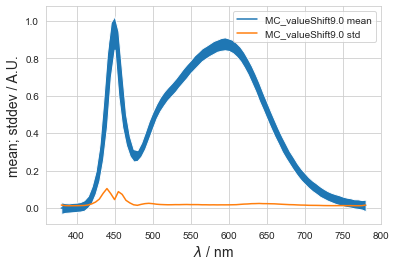

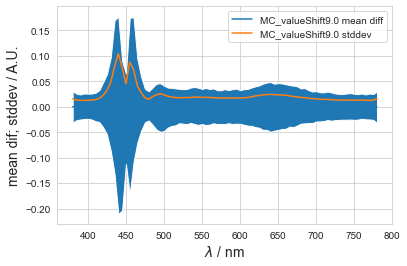

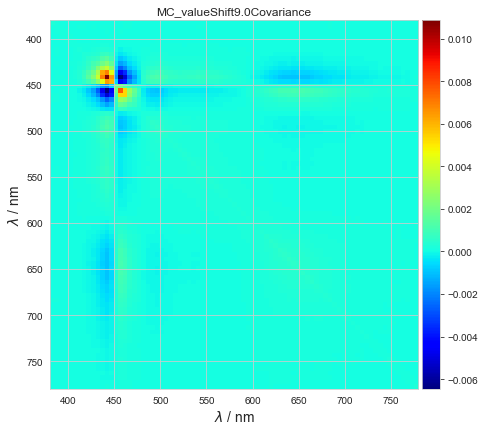

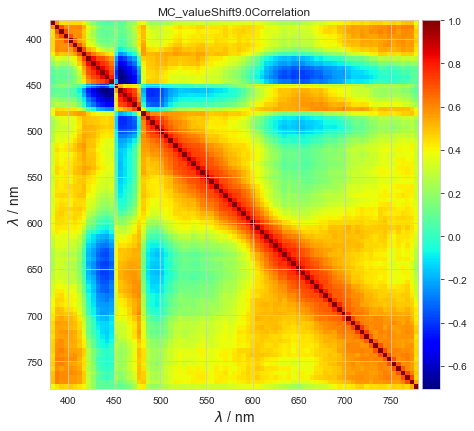

chisquare: 103.00950871222618
Difference Vecotr: [-8.7782e-04 2.4705e-05 -1.3933e-03 -3.8573e-03 -8.6712e-03 -2.0331e-02
 -4.4599e-02 -8.2893e-02 -1.4081e-01 -2.2670e-01 -3.5716e-01 -4.6733e-01
 -3.2377e-01 8.3399e-02 3.7696e-01 3.4379e-01 2.0670e-01 1.2313e-01
 4.8804e-02 -2.3541e-02 -7.0016e-02 -9.4930e-02 -1.0303e-01 -9.3327e-02
 -7.7488e-02 -6.1545e-02 -4.8784e-02 -4.2239e-02 -4.0901e-02 -4.2284e-02
 -4.4560e-02 -4.6560e-02 -4.5804e-02 -4.3206e-02 -3.9427e-02 -3.5022e-02
 -3.0929e-02 -2.6307e-02 -2.2441e-02 -1.9474e-02 -1.5573e-02 -9.0653e-03
 -1.0653e-03 9.4622e-03 2.2252e-02 3.5457e-02 4.8139e-02 5.9781e-02
 6.9103e-02 7.7887e-02 8.5042e-02 8.7607e-02 8.8685e-02 8.8190e-02
 8.6175e-02 8.2414e-02 7.9888e-02 7.4304e-02 6.7645e-02 6.2513e-02
 5.6316e-02 5.0429e-02 4.4692e-02 4.1064e-02 3.6087e-02 3.1855e-02
 2.7355e-02 2.3635e-02 2.0277e-02 1.8348e-02 1.4978e-02 1.3163e-02
 1.1964e-02 1.0021e-02 8.0275e-03 7.5436e-03 6.5637e-03 5.4068e-03
 5.6303e-03 4.9530e-03 4.4309e-03] 1.0110671

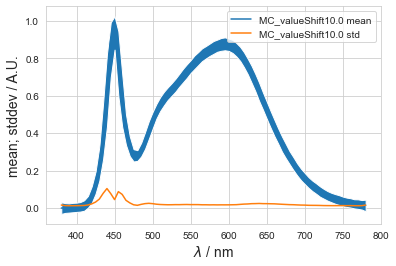

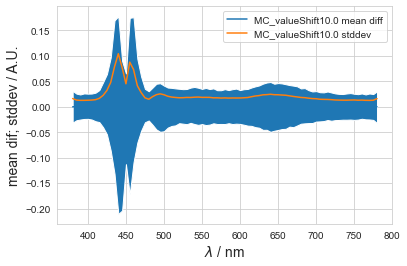

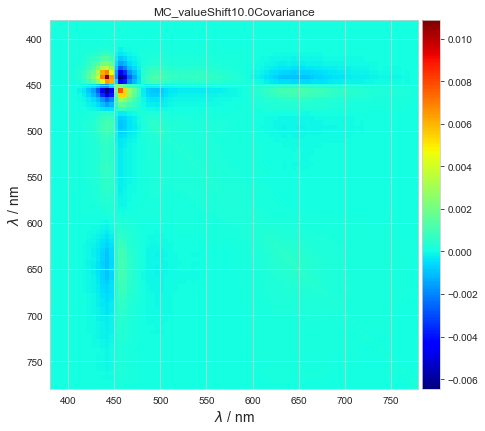

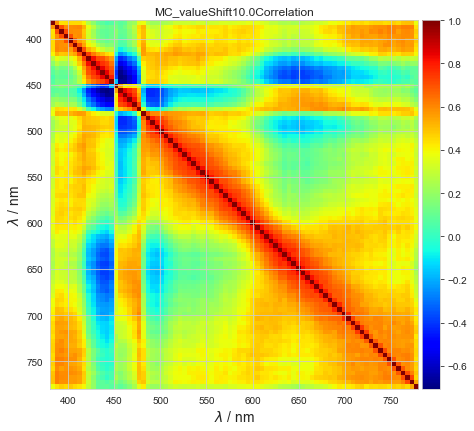

C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\481653026.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


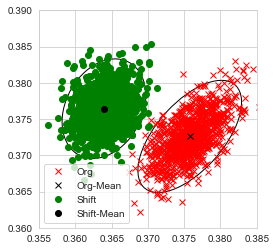

chisquare: 5.991464547107979
Difference Vecotr: [1.1837e-02 -3.8279e-03] 0.012440893042302293
Resulting Covariance Matrix: [[1.4078e-05 7.3739e-06]
 [7.3739e-06 1.7832e-05]]
dy: 0.007353019460178155
DoE: 1.6919434403347635


C:\Users\udo.krueger\AppData\Local\Temp\ipykernel_14620\1850479778.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True)


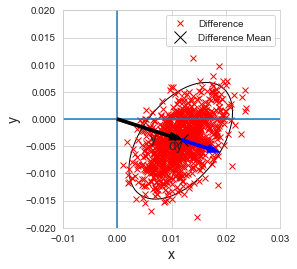

           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375635  1.045534e-03   
0           wl_noise_c    0    1.0  0       normal  0.375706  1.347531e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375649  1.763443e-03   
0       value_noise_nc    0   0.01  0       normal  0.375607  5.227782e-04   
0        value_noise_c    0   0.01  0       normal  0.375608  6.661094e-04   
0  value_fourier_noise    0   0.01  4            F  0.375591  9.475540e-04   
0                  all                              0.375770  2.917622e-03   

    p95Minx   p95Maxx         y            sy   p95Miny   p95Maxy  
0  0.375604  0.375604  0.372289  1.110223e-16  0.372289  0.372289  
0  0.375602  0.375702  0.372429  1.665820e-03  0.372313  0.372546  
0  0.375623  0.375779  0.372453  1.299895e-04  0.372419  0.372434  
0  0.375540  0.375752  0.

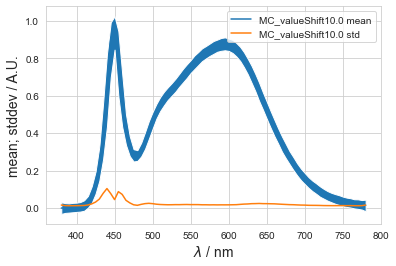

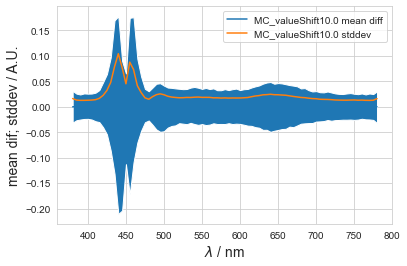

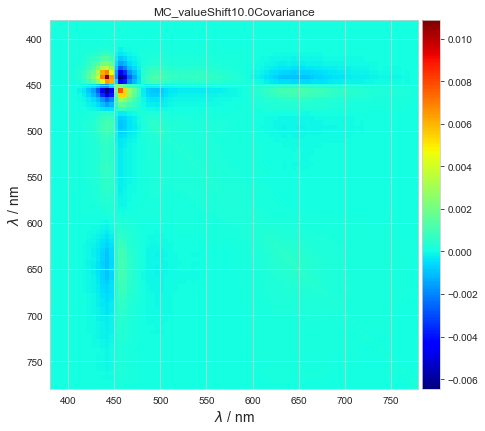

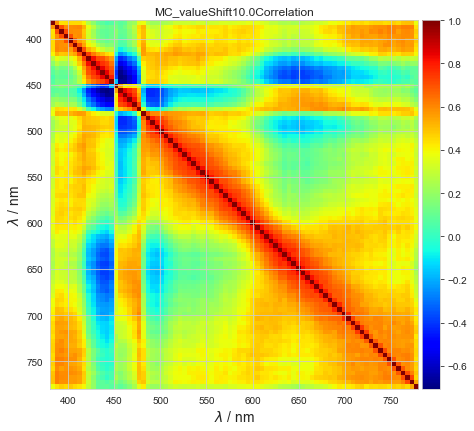

chisquare: 103.00950871222618
Difference Vecotr: [-5.8795e-04 -9.1700e-04 -1.9734e-03 -4.7604e-03 -1.0857e-02 -2.5816e-02
 -5.3471e-02 -9.8516e-02 -1.6340e-01 -2.6217e-01 -4.1235e-01 -5.0681e-01
 -3.1083e-01 1.2806e-01 4.1365e-01 3.6407e-01 2.1869e-01 1.2816e-01
 4.5789e-02 -3.1330e-02 -7.9906e-02 -1.0564e-01 -1.1329e-01 -1.0103e-01
 -8.4458e-02 -6.6746e-02 -5.3890e-02 -4.6966e-02 -4.6484e-02 -4.8168e-02
 -5.0629e-02 -5.1786e-02 -5.0589e-02 -4.7786e-02 -4.4200e-02 -3.9316e-02
 -3.4913e-02 -2.9487e-02 -2.5625e-02 -2.1528e-02 -1.6963e-02 -9.3995e-03
 -7.5436e-05 1.1603e-02 2.5091e-02 4.0781e-02 5.3977e-02 6.7023e-02
 7.8124e-02 8.6530e-02 9.3394e-02 9.6483e-02 9.8232e-02 9.8690e-02
 9.4925e-02 9.0378e-02 8.6981e-02 8.0221e-02 7.3167e-02 6.7898e-02
 6.1568e-02 5.4949e-02 4.9237e-02 4.3555e-02 3.8808e-02 3.3800e-02
 3.0331e-02 2.6574e-02 2.2548e-02 1.9699e-02 1.6739e-02 1.4857e-02
 1.2991e-02 1.1287e-02 8.9550e-03 7.9223e-03 6.6614e-03 5.9556e-03
 5.9023e-03 5.5030e-03 5.4717e-03] 1.103645

In [37]:
sample_number = 10
shift_range = 10
shift_field = np.zeros((sample_number))
DoE_xy = np.zeros((sample_number))
DoE_md = np.zeros((sample_number))
for i, shift in zip(range( sample_number), np.linspace(1, shift_range, sample_number)):
    shift_field[i]=shift
    spd_wlshift = lx.cie_interp(spd_init, \
            wl_new = shift + np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)
    spd_wlshift[0] = spd_init[0]
    mcSpectrumSamples2 = make2ndMC(shift, spd_wlshift)
    plotxySingle(shift, mcSpectrumSamples2)
    x1, cov1 = calcMeanCov(mcSpectrumSamples)
    x2, cov2 = calcMeanCov(mcSpectrumSamples2)
    d, dy, V, data = calc_multiDim_DoE(x1, cov1, x2, cov2)
    plot_multi_DoE(shift, d, dy, V, data)
    cov_image2 = showResults(mcSpectrumSamples, 'MC_valueShift'+str(shift))
    sd1 = mcSpectrumSamples.v_mean
    sd2 = mcSpectrumSamples2.v_mean
    d1, dy1, V1, data1 = calc_multiDim_DoE(sd1, cov_image, sd2, cov_image2)
    DoE_xy[i] = 1/dy
    DoE_md[i] = 1/dy1

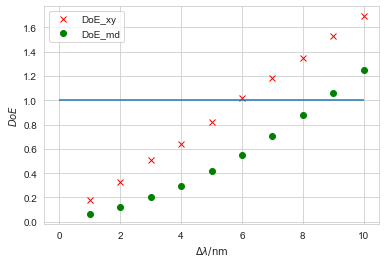

In [38]:
pyplot.plot( shift_field, DoE_xy, 'rx', label='DoE_xy')
pyplot.plot( shift_field, DoE_md, 'go', label='DoE_md')
pyplot.xlabel('$\Delta \lambda / \mathrm{nm}$')
pyplot.ylabel('$DoE$')
pyplot.hlines(1, xmin=0, xmax=shift_range)
pyplot.legend()
save_fig(dir=out_dir, filename='DoeSum')